In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from joblib import Parallel, delayed
from pathlib import Path
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [3]:
import os
print(os.path.getsize("data/df_confe.csv") / (1024**3), "GB")


2.5967229744419456 GB


In [17]:


# Leer CSV completo
data = pl.read_csv("data/df_confe.csv")

print(data.shape)        # filas, columnas
print(data.head())


(978439, 755)
shape: (5, 755)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ numero_de ┆ foto_mes ┆ active_qu ┆ cliente_v ┆ … ┆ Visa_cade ┆ Visa_cade ┆ Visa_mpag ┆ Visa_mpag │
│ _cliente  ┆ ---      ┆ arter     ┆ ip        ┆   ┆ lantosefe ┆ lantosefe ┆ ominimo_d ┆ ominimo_d │
│ ---       ┆ i64      ┆ ---       ┆ ---       ┆   ┆ ctivo_dif ┆ ctivo_dif ┆ iff_prev  ┆ iff_prev2 │
│ i64       ┆          ┆ i64       ┆ i64       ┆   ┆ f_p…      ┆ f_p…      ┆ ---       ┆ ---       │
│           ┆          ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│           ┆          ┆           ┆           ┆   ┆ i64       ┆ i64       ┆           ┆           │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 249320580 ┆ 202101   ┆ 1         ┆ 0         ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 249320580 ┆ 202102   ┆ 1         ┆ 0         ┆ … ┆ null    

In [4]:
# Filtrar los meses deseados
df_filtrado = data.filter(
    (data["foto_mes"] == 202103) | (data["foto_mes"] == 202104)
)

# Guardar en CSV
df_filtrado.write_csv("df_confe_ma.csv")

In [4]:
df_filtrado = pl.read_csv("data/df_confe_ma.csv")
print(os.path.getsize("data/df_confe_ma.csv") / (1024**3), "GB")

0.9480155138298869 GB


In [18]:
# Filtrar los meses deseados
df_kaggle = data.filter(
    (data["foto_mes"] == 202106))

# Guardar en CSV
df_kaggle.write_csv("df_confe_kaggle.csv")

In [20]:
df_kaggle = pl.read_csv("data/df_confe_kaggle.csv")
print(os.path.getsize("data/df_confe_kaggle.csv") / (1024**3), "GB")

0.4791595805436373 GB


In [5]:
#tiene "clase_ternaria"?
print("clase_ternaria" in df_filtrado.columns)

True


In [6]:
SEMILLAS = [550007, 550019, 550031, 550033, 550047]

mes_train = 202103
mes_test = 202104
mes_kaggle = 202106
ganancia_acierto = 780000
costo_estimulo = 20000
# =====================

In [10]:
# Filtrar solo el mes de train
df_train = df_filtrado.filter(pl.col("foto_mes") == mes_train)

# Contar nulos por columna
null_counts = (
    df_train.select([
        pl.col(col).null_count().alias(col) for col in df_train.columns
    ])
    .to_dict(as_series=False)
)

# Pasarlo a un DataFrame ordenado
null_df = (
    pl.DataFrame({
        "columna": list(null_counts.keys()),
        "nulos": [v[0] for v in null_counts.values()]
    })
    .sort("nulos", descending=True)
)


# Imprimir las primeras 15 filas
print(null_df.head(15))

shape: (15, 2)
┌─────────────────────────────────┬────────┐
│ columna                         ┆ nulos  │
│ ---                             ┆ ---    │
│ str                             ┆ i64    │
╞═════════════════════════════════╪════════╡
│ Master_Finiciomora              ┆ 162022 │
│ Visa_Finiciomora                ┆ 161595 │
│ Master_mconsumospesos_diff_pre… ┆ 103491 │
│ Master_mconsumosdolares_diff_p… ┆ 103491 │
│ Master_madelantopesos_diff_pre… ┆ 103491 │
│ …                               ┆ …      │
│ Master_cadelantosefectivo_diff… ┆ 103491 │
│ Master_mconsumospesos_diff_pre… ┆ 100125 │
│ Master_mconsumosdolares_diff_p… ┆ 100125 │
│ Master_madelantopesos_diff_pre… ┆ 100125 │
│ Master_madelantodolares_diff_p… ┆ 100125 │
└─────────────────────────────────┴────────┘


In [11]:

#cuantas filas tiene el dataframe
n_filas = df_train.height    
# Imprimir las primeras 20 filas
print(null_df.head(20))

shape: (20, 2)
┌─────────────────────────────────┬────────┐
│ columna                         ┆ nulos  │
│ ---                             ┆ ---    │
│ str                             ┆ i64    │
╞═════════════════════════════════╪════════╡
│ Master_Finiciomora              ┆ 162022 │
│ Visa_Finiciomora                ┆ 161595 │
│ Master_mconsumospesos_diff_pre… ┆ 103491 │
│ Master_mconsumosdolares_diff_p… ┆ 103491 │
│ Master_madelantopesos_diff_pre… ┆ 103491 │
│ …                               ┆ …      │
│ Master_mpagospesos_diff_prev    ┆ 100125 │
│ Master_mpagosdolares_diff_prev  ┆ 100125 │
│ Master_mconsumototal_diff_prev  ┆ 100125 │
│ Master_cconsumos_diff_prev      ┆ 100125 │
│ Master_cadelantosefectivo_diff… ┆ 100125 │
└─────────────────────────────────┴────────┘


In [12]:
#tiene mi df_train la columna "clase_ternaria"?
print("clase_ternaria" in df_train.columns)

True


In [ ]:
# Filtrar train
#X = data.filter(pl.col("foto_mes") == mes_train)
#y = X["clase_ternaria"]
#X = X.drop("clase_ternaria")

# Filtrar validación/futuro
#X_futuro = data.filter(pl.col("foto_mes") == mes_test)
#y_futuro = X_futuro["clase_ternaria"]
#X_futuro = X_futuro.drop("clase_ternaria")


In [8]:

def ganancia_prob(y_hat, y, prop=1, class_index=1, threshold=0.025):
  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop


     

In [15]:

# -------------------
# Filtrar mes_train
# -------------------
df_train_full = df_train.filter(pl.col("foto_mes") == mes_train)

# Separar X e y
X = df_train_full.drop("clase_ternaria")
y = df_train_full["clase_ternaria"]

# -------------------
# Split 70/30
# -------------------
X_train, X_val, y_train, y_val = train_test_split(
    X.to_pandas(),  # sklearn necesita DataFrame de pandas
    y.to_pandas(),
    train_size=0.7,
    random_state=1234,
    stratify=y  # para mantener proporción de clases
)

# -------------------
# Ver tamaño de cada conjunto
# -------------------
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
# -------------------
# Definición del objetivo para Optuna
# -------------------
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 200),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 5, 50),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 1234,
        "n_jobs": -1,
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_train)
    ganancia = ganancia_prob(y_pred, y_train)

    return ganancia  # Optuna va a maximizar esto


# -------------------
# Ejecutar la optimización
# -------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # podés aumentar trials para mejor resultado

print("Mejores hiperparámetros:", study.best_params)
print("Ganancia en TRAIN con esos parámetros:", study.best_value)

[I 2025-10-03 11:19:49,131] A new study created in memory with name: no-name-09872dcc-da7f-44cf-b09d-da7d516b39d9


Train: (114176, 754) (114176,)
Validation: (48933, 754) (48933,)


[I 2025-10-03 11:20:23,363] Trial 0 finished with value: 178040000.0 and parameters: {'n_estimators': 135, 'max_depth': 29, 'min_samples_split': 40, 'min_samples_leaf': 1, 'max_leaf_nodes': 25, 'criterion': 'gini'}. Best is trial 0 with value: 178040000.0.
[I 2025-10-03 11:22:35,033] Trial 1 finished with value: 220480000.0 and parameters: {'n_estimators': 421, 'max_depth': 26, 'min_samples_split': 59, 'min_samples_leaf': 87, 'max_leaf_nodes': 50, 'criterion': 'entropy'}. Best is trial 1 with value: 220480000.0.
[I 2025-10-03 11:23:54,801] Trial 2 finished with value: 194780000.0 and parameters: {'n_estimators': 404, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 88, 'max_leaf_nodes': 36, 'criterion': 'gini'}. Best is trial 1 with value: 220480000.0.
[I 2025-10-03 11:26:00,344] Trial 3 finished with value: 215000000.0 and parameters: {'n_estimators': 380, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 79, 'max_leaf_nodes': 46, 'criterion': 'entropy'}. Best is

Mejores hiperparámetros: {'n_estimators': 343, 'max_depth': 22, 'min_samples_split': 94, 'min_samples_leaf': 37, 'max_leaf_nodes': 50, 'criterion': 'entropy'}
Ganancia en TRAIN con esos parámetros: 229240000.0


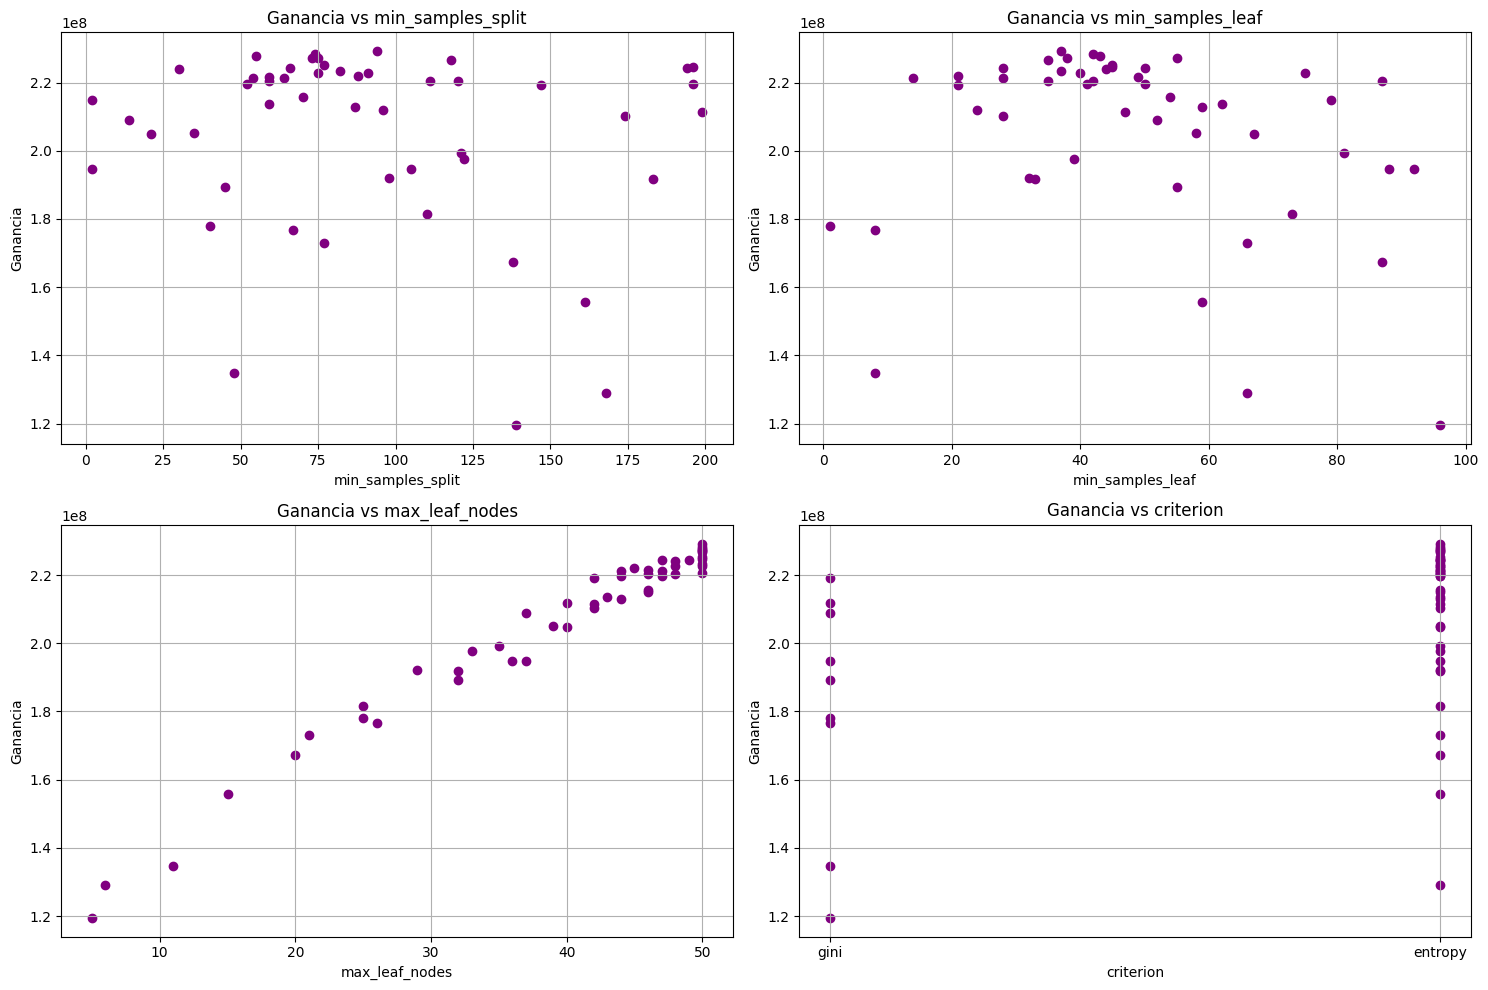

In [20]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Extraer datos de los trials
param_names = ["min_samples_split", "min_samples_leaf", "max_leaf_nodes", "criterion"]
ganancias = [t.value for t in study.trials]

# Graficar cada parámetro
plt.figure(figsize=(15,10))

for i, param in enumerate(param_names, 1):
    param_values = [t.params.get(param) for t in study.trials]
    
    plt.subplot(2, 2, i)
    plt.scatter(param_values, ganancias, color='purple')
    plt.xlabel(param)
    plt.ylabel("Ganancia")
    plt.title(f"Ganancia vs {param}")
    plt.grid(True)

plt.tight_layout()
plt.show()


Mejores hip:
n_estimators e/ 250 y 350
max_depht e/ 20 y 25
min_sample_split e/ 50 y 90
min_sample_leaf e/30 y 50
criterion: entropy
max_leaf_nodes e45 y cuanto?? todas en 50

In [9]:
# Filtrar train
X = df_filtrado.filter(pl.col("foto_mes") == mes_train)
y = X["clase_ternaria"]
X = X.drop("clase_ternaria")

# Filtrar validación/futuro
X_futuro = df_filtrado.filter(pl.col("foto_mes") == mes_test)
y_futuro = X_futuro["clase_ternaria"]
X_futuro = X_futuro.drop("clase_ternaria")


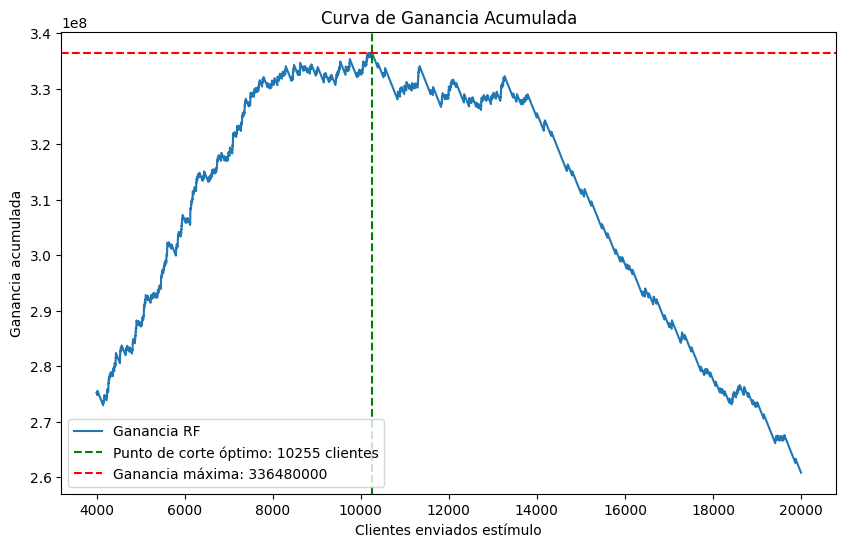

Punto de corte óptimo: 10255 clientes
Ganancia máxima alcanzable: 336480000


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# Predecir probabilidades sobre X_futuro
# -------------------
y_prob = model_opt.predict_proba(X_futuro)[:, 1]  # asumimos "BAJA+2" es index 1
y_true = y_futuro.to_numpy()  # etiquetas reales

# -------------------
# Ordenar por probabilidad descendente
# -------------------
idx_sort = np.argsort(y_prob)[::-1]
y_true_sorted = y_true[idx_sort]


ganancia_cum = np.cumsum([
    (ganancia_acierto if y=="BAJA+2" else -costo_estimulo)
    for y in y_true_sorted
])

# -------------------
# Definir rango de clientes a estimular
# -------------------
piso_envios = 4000
techo_envios = 20000

# -------------------
# Encontrar índice de ganancia máxima
# -------------------
ganancia_max = ganancia_cum[piso_envios:techo_envios].max()
gan_max_idx = np.argmax(ganancia_cum[piso_envios:techo_envios]) + piso_envios

# -------------------
# Graficar
# -------------------
plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, techo_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia RF')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte óptimo: {gan_max_idx} clientes')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima: {ganancia_max}')
plt.title('Curva de Ganancia Acumulada')
plt.xlabel('Clientes enviados estímulo')
plt.ylabel('Ganancia acumulada')
plt.legend()
plt.show()

print(f"Punto de corte óptimo: {gan_max_idx} clientes")
print(f"Ganancia máxima alcanzable: {ganancia_max}")


In [15]:
# y_prob ya ordenado de mayor a menor
idx_sort = np.argsort(y_prob)[::-1]
y_prob_sorted = y_prob[idx_sort]

# Threshold aproximado para estimular gan_max_idx clientes
threshold_opt = y_prob_sorted[gan_max_idx - 1]  # restamos 1 por índice 0-based

print(f"Threshold aproximado para estimular {gan_max_idx} clientes: {threshold_opt:.4f}")


Threshold aproximado para estimular 10255 clientes: 0.0211


In [ ]:
#Parametros optimizados
#param_opt = {'criterion': 'entropy',
             'max_depth': 20,
             'min_samples_split': 145,
             'min_samples_leaf': 14,
             'max_leaf_nodes': 13}

#model_opt = RandomForestClassifier(random_state=SEMILLAS[0], **param_opt)

#model_opt.fit(X, y)
#y_pred_opt = model_opt.predict_proba(X_futuro)
#print(f"Ganancia de modelo Opt: {ganancia_prob(y_pred_opt, y_futuro)}")

MemoryError: Unable to allocate 933. MiB for an array with shape (754, 162155) and data type object

#Ganancia modelo clase 211 MARS sin nada
Ganancia modelo optimizaod acá, 331 mars

## DF FINAL KAGGLE


In [29]:
# Datos de entrenamiento
# -------------------
train_data = df_filtrado  # ya es un DataFrame de Polars

# X_train: todas menos clase_ternaria
X_train = train_data.drop("clase_ternaria").to_pandas()  # convertir a pandas para sklearn
y_train = train_data.select("clase_ternaria").to_numpy().ravel()  # NumPy array
from sklearn.preprocessing import LabelEncoder

# Detectar columnas object
cols_object_train = X_train.select_dtypes(include=['object']).columns
cols_object_kaggle = X_kaggle.select_dtypes(include=['object']).columns

# Asegurarse de que las mismas columnas estén en ambos datasets
cols_object = list(set(cols_object_train) | set(cols_object_kaggle))

# Convertir cada columna object a numérica
for col in cols_object:
    le = LabelEncoder()
    
    # Fit en el dataset de entrenamiento
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    
    # Transformar el dataset de Kaggle con el mismo encoder
    if col in X_kaggle.columns:
        X_kaggle[col] = le.transform(X_kaggle[col].astype(str))

# Ahora todas las columnas son numéricas
print(X_train.dtypes.value_counts())
print(X_kaggle.dtypes.value_counts())


# Datos de Kaggle
X_kaggle = df_kaggle
clientes_kaggle = X_kaggle['numero_de_cliente']
X_kaggle = X_kaggle.drop('clase_ternaria').to_pandas()  # numero_de_cliente queda

# Modelo
param_opt = {'criterion': 'entropy',
             'max_depth': 20,
             'min_samples_split': 70,
             'min_samples_leaf': 50,
             'max_leaf_nodes': 45}

model_opt = RandomForestClassifier(random_state=SEMILLAS[0], **param_opt)
model_opt.fit(X_train, y_train)

# Predicciones probabilísticas
y_pred_prob = model_opt.predict_proba(X_kaggle)

# Transformar probabilidades en 0/1 con threshold 0.025
threshold = 0.025
class_index = list(model_opt.classes_).index("BAJA+2")
y_pred_bin = (y_pred_prob[:, class_index] > threshold).astype(int)

# Crear DataFrame final con las dos columnas
submission = pd.DataFrame({
    'numero_de_cliente': clientes_kaggle,
    'Predicted': y_pred_bin
})

submission.to_csv("predicciones_kaggle.csv", index=False)
submission.head()

ArrowMemoryError: malloc of size 1468065408 failed

In [26]:
# -------------------
# 1️⃣ Revisar forma y tipos
# -------------------
print("X_train shape:", X_train.shape)
print("Tipos de columnas en X_train:")
print(X_train.dtypes.value_counts())  # cuántas columnas de cada tipo

print("\nX_kaggle shape:", X_kaggle.shape)
print("Tipos de columnas en X_kaggle:")
print(X_kaggle.dtypes.value_counts())


X_train shape: (326527, 754)
Tipos de columnas en X_train:
float64    562
int64      191
object       1
Name: count, dtype: int64

X_kaggle shape: (164313, 754)
Tipos de columnas en X_kaggle:
float64    561
int64      191
object       2
Name: count, dtype: int64


In [28]:
# Ver columnas object
print(X_train.select_dtypes(include=['object']).columns)
print(X_kaggle.select_dtypes(include=['object']).columns)




Index(['Master_Finiciomora'], dtype='object')
Index(['Master_Finiciomora', 'Visa_Finiciomora'], dtype='object')


In [ ]:
# Número de filas
print(submission.shape)  # devuelve (filas, columnas)

# Columnas
print(submission.columns)  # debe dar Index(['numero_de_cliente', 'Predicted'], dtype='object')

(164313, 2)
Index(['numero_de_cliente', 'Predicted'], dtype='object')
